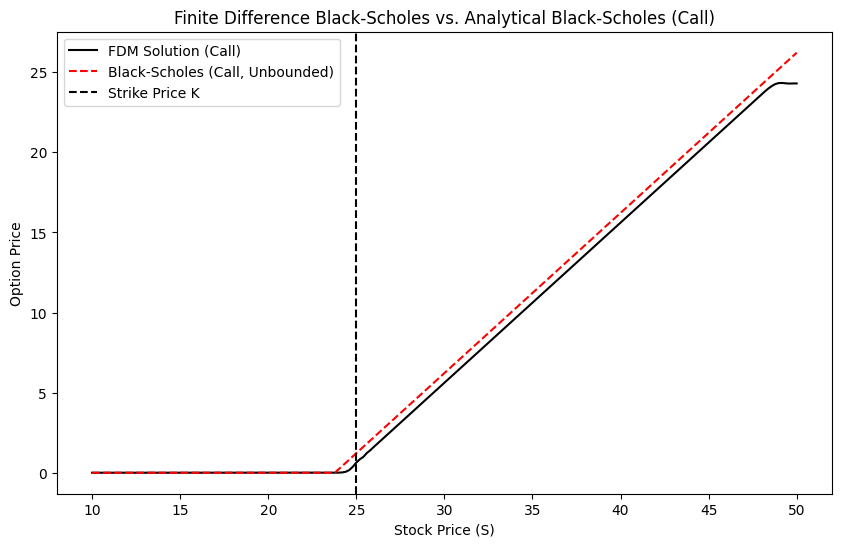

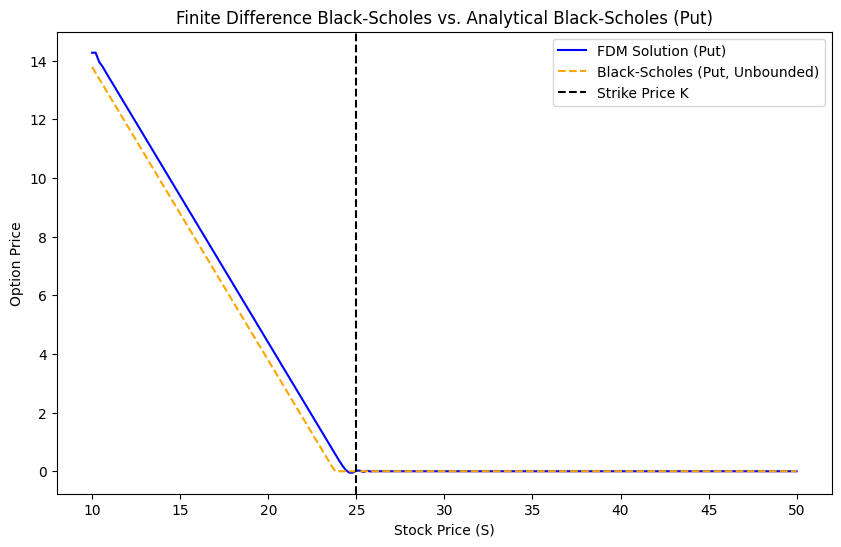

Call Option Price at S0=25: FDM=0.6354331235192715, Black-Scholes=1.2192643874821485
Put Option Price at S0=25: FDM=0.018219019126254316, Black-Scholes=0.0


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded

def black_scholes_price(S0, K, T, r, sigma, option_type="call"):
    """Compute the Black-Scholes option price."""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call", M=200, N=200):
    """Solve the bounded Black-Scholes equation using the Finite Difference Method (FDM) for calls and puts."""
    dS = (S_max - S_min) / M  # Stock price step
    dt = T / N  # Time step
    S_vals = np.linspace(S_min, S_max, M+1)
    
    # Initialize option price grid
    if option_type == "call":
        V = np.maximum(S_vals - K, 0)  # Payoff at maturity for a call
    elif option_type == "put":
        V = np.maximum(K - S_vals, 0)  # Payoff at maturity for a put
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    V = np.tile(V, (N+1, 1)).T  # Replicate for all time steps
    
    # Crank-Nicolson coefficients
    alpha = 0.25 * sigma**2 * (S_vals[1:-1]**2) / dS**2
    beta = 0.25 * r * S_vals[1:-1] / dS
    
    A = -alpha + beta
    B = 1/dt + 2*alpha + r/2
    C = -alpha - beta
    
    # Tridiagonal system setup
    lower_diag = np.zeros(M-2)
    main_diag = np.zeros(M-1)
    upper_diag = np.zeros(M-2)
    
    lower_diag[:] = A[1:]
    main_diag[:] = B
    upper_diag[:] = C[:-1]
    
    # Backward induction with Crank-Nicolson
    for n in range(N-1, -1, -1):
        rhs = V[1:-1, n+1] / dt
        rhs[0] -= A[0] * V[0, n+1]  # Neumann BC at S_min
        rhs[-1] -= C[-1] * V[-1, n+1]  # Neumann BC at S_max
        
        # Solve tridiagonal system
        A_matrix = np.zeros((3, M-1))
        A_matrix[0, 1:] = upper_diag
        A_matrix[1, :] = main_diag
        A_matrix[2, :-1] = lower_diag
        
        V[1:-1, n] = solve_banded((1, 1), A_matrix, rhs)
        
        # Apply Neumann BCs
        V[0, n] = V[1, n]
        V[-1, n] = V[-2, n]
    
    V_S0 = V[np.argmin(np.abs(S_vals - S0)), 0]  # Extract price at S0
    return S_vals, V[:, 0], V_S0

# Parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 50  # Bounded domain
K = 25  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate
sigma = 0.00000000000001 # Volatility

# Compute Black-Scholes and FDM prices for a call option
S_vals, V_fdm_call, V_fdm_S0_call = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call")
bs_price_S0_call = black_scholes_price(S0, K, T, r, sigma, option_type="call")
bs_prices_call = np.array([black_scholes_price(S, K, T, r, sigma, option_type="call") for S in S_vals])

# Compute Black-Scholes and FDM prices for a put option
S_vals, V_fdm_put, V_fdm_S0_put = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="put")
bs_price_S0_put = black_scholes_price(S0, K, T, r, sigma, option_type="put")
bs_prices_put = np.array([black_scholes_price(S, K, T, r, sigma, option_type="put") for S in S_vals])

# Plot comparison for call options
plt.figure(figsize=(10, 6))
plt.plot(S_vals, V_fdm_call, label="FDM Solution (Call)", linestyle="solid", color="black")
plt.plot(S_vals, bs_prices_call, label="Black-Scholes (Call, Unbounded)", linestyle="dashed", color="red")
plt.axvline(K, color="k", linestyle="--", label="Strike Price K")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price")
plt.title("Finite Difference Black-Scholes vs. Analytical Black-Scholes (Call)")
plt.legend()
plt.show()

# Plot comparison for put options
plt.figure(figsize=(10, 6))
plt.plot(S_vals, V_fdm_put, label="FDM Solution (Put)", linestyle="solid", color="blue")
plt.plot(S_vals, bs_prices_put, label="Black-Scholes (Put, Unbounded)", linestyle="dashed", color="orange")
plt.axvline(K, color="k", linestyle="--", label="Strike Price K")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price")
plt.title("Finite Difference Black-Scholes vs. Analytical Black-Scholes (Put)")
plt.legend()
plt.show()

# Print option prices at S0
print(f"Call Option Price at S0={S0}: FDM={V_fdm_S0_call}, Black-Scholes={bs_price_S0_call}")
print(f"Put Option Price at S0={S0}: FDM={V_fdm_S0_put}, Black-Scholes={bs_price_S0_put}")

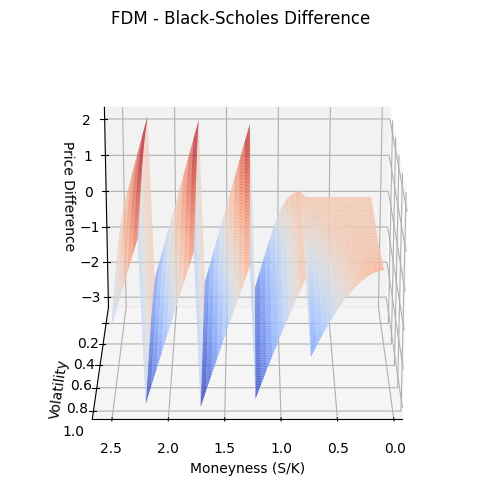

In [42]:
# Parameters
S_min, S_max = 0, 1000 # Bounded domain
K = 10  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate

# Define volatility and moneyness range
volatilities = np.linspace(0.1, 1, 50)
moneyness = np.linspace(0.1, 2.5, 50)
M, V = np.meshgrid(moneyness, volatilities)

# Compute option prices using BS and FDM
bs_prices_surface = np.array([[black_scholes_price(K * m, K, T, r, v, "call") for m in moneyness] for v in volatilities])
fdm_prices_surface = np.array([[finite_difference_black_scholes(K * m, S_min, S_max, K, T, r, v, "call")[2] for m in moneyness] for v in volatilities])

# Compute the difference
price_difference_surface = fdm_prices_surface - bs_prices_surface

# Plot the difference surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(M, V, price_difference_surface, cmap='coolwarm')
ax.view_init(elev=20, azim=90)  # Adjust rotation
ax.set_title("FDM - Black-Scholes Difference")
ax.set_xlabel("Moneyness (S/K)")
ax.set_ylabel("Volatility")
ax.set_zlabel("Price Difference")

plt.show()